# _Data Labelling & Model Training - Livin' by Mandiri from Google Play Store_

---

##### _Made by: Rasendra Akbar Satyatama_ - MC004D5Y1124

### 1. Import _Libraries_ & Hasil Scraping

In [56]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
import pickle

In [2]:
data = pd.read_csv("hasil_scraping.csv", index_col='ID')
data

,content
ID,
1,aplikasi ini sangat membantu saya
2,sangat membantu
3,berulang kali masuk kan data pribadi gagal tru...
4,sangat membantu
5,assalamualaikum min. saya lupaa pasword livin ...
...,...
9996,Loding parah
9997,Mau daftar online kenapa susah ya Apalagi untu...
9998,Sya compalain mlsh slado krna pndptn sya skian...


### 2. _Text Preprocessing_

In [3]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rasen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Rasen\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Rasen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#### 2. a) Removal Special Characters & Case Folding

In [4]:
def remove_emoji(text):
    if text is not None and isinstance(text, str):
        emoji_pattern = re.compile(
            u"[\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA00-\U0001FA6F"  # Chess Symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0001FC00-\U0001FCFF"  # Additional emoticons
            u"\U0001F1E0-\U0001F1FF"  # flags
            "]+", flags=re.UNICODE
        )
        return emoji_pattern.sub(r'', text)
    else:
        return text

def remove_URL(text):
    if text is not None and isinstance(text, str):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', text)
    else:
        return text

def remove_html(text):
    if text is not None and isinstance(text, str):
        html = re.compile(r'<.*?>')
        return html.sub(r'', text)
    else:
        return text

def remove_symbols(text):
    if text is not None and isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return text

def remove_numbers(text):
    if text is not None and isinstance(text, str):
        text = re.sub(r'\d','', text)
    return text

In [5]:
data['cleaning'] = data['content'].apply(remove_emoji)
data['cleaning'] = data['cleaning'].apply(remove_URL)
data['cleaning'] = data['cleaning'].apply(remove_html)
data['cleaning'] = data['cleaning'].apply(remove_symbols)
data['cleaning'] = data['cleaning'].apply(remove_numbers)
data['cleaning'] = data['cleaning'].str.lower()

#### 2. b) Menghapus huruf berulang (Maks 2 huruf)

Karna ada beberapa istilah yang menggunakan huruf berulang 2 kali sehingga dibatasi maksimal 2 huruf berulang, selain istilah - istilah tersebut akan di-celaning dengan kamus kata baku

In [6]:
def normalize_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [7]:
data['cleaning'] = data['cleaning'].apply(normalize_repeated_chars)

In [8]:
data

,content,cleaning
ID,,
1,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya
2,sangat membantu,sangat membantu
3,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal tru...
4,sangat membantu,sangat membantu
5,assalamualaikum min. saya lupaa pasword livin ...,assalamualaikum min saya lupaa pasword livin ...
...,...,...
9996,Loding parah,loding parah
9997,Mau daftar online kenapa susah ya Apalagi untu...,mau daftar online kenapa susah ya apalagi untu...
9998,Sya compalain mlsh slado krna pndptn sya skian...,sya compalain mlsh slado krna pndptn sya skian...


#### 2. c) Kata Baku Bahasa Indonesia

'kamuskatabaku.xlsx' yang dilampirkan pada folder .zip ini bersumber dari link github berikut https://github.com/agushendra7/twitter-sentiment-analysis-using-inset-and-random-forest yang kemudian saya tambahkan beberapa kata beserta kata baku nya sesuai KBBI

In [9]:
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = text.split()
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                    replaced_words.append(baku_word)
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
            else:
                replaced_words.append(word)
        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []
    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

In [10]:
kamus_data = pd.read_excel("kamuskatabaku.xlsx")
kamus_tidak_baku = dict(zip(kamus_data['tidak_baku'],kamus_data['kata_baku']))

In [11]:
data['baku'], data['Kata_Baku'], data['Kata_Tidak_Baku'], data['Kata_Tidak_Baku_Hash'] = zip(*data['cleaning'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku)))

In [12]:
data = pd.DataFrame(data[['content', 'cleaning', 'baku']])
data

,content,cleaning,baku
ID,,,
1,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya
2,sangat membantu,sangat membantu,sangat membantu
3,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal ter...
4,sangat membantu,sangat membantu,sangat membantu
5,assalamualaikum min. saya lupaa pasword livin ...,assalamualaikum min saya lupaa pasword livin ...,assalamualaikum min saya lupa pasword livin sa...
...,...,...,...
9996,Loding parah,loding parah,loading parah
9997,Mau daftar online kenapa susah ya Apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,mau daftar online kenapa susah ya apalagi untu...
9998,Sya compalain mlsh slado krna pndptn sya skian...,sya compalain mlsh slado krna pndptn sya skian...,saya complain masalah saldo karena pendapatan ...


### 2. d) Tokenizing

In [13]:
def tokenize(text):
    return word_tokenize(text)

In [14]:
data['tokenized'] = data['baku'].apply(tokenize)

In [15]:
data

,content,cleaning,baku,tokenized
ID,,,,
1,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,"[aplikasi, ini, sangat, membantu, saya]"
2,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]"
3,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal ter...,"[berulang, kali, masuk, kan, data, pribadi, ga..."
4,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]"
5,assalamualaikum min. saya lupaa pasword livin ...,assalamualaikum min saya lupaa pasword livin ...,assalamualaikum min saya lupa pasword livin sa...,"[assalamualaikum, min, saya, lupa, pasword, li..."
...,...,...,...,...
9996,Loding parah,loding parah,loading parah,"[loading, parah]"
9997,Mau daftar online kenapa susah ya Apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,"[mau, daftar, online, kenapa, susah, ya, apala..."
9998,Sya compalain mlsh slado krna pndptn sya skian...,sya compalain mlsh slado krna pndptn sya skian...,saya complain masalah saldo karena pendapatan ...,"[saya, complain, masalah, saldo, karena, penda..."


### 2. e) Stopword Removal

In [16]:
def stopwordremoval(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['min','nah','oh','iya','yaa','gak','nya','na','sih','si','ku',
                          "di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [17]:
data['stopword_removed'] = data['tokenized'].apply(lambda x: stopwordremoval(x))

In [18]:
data

,content,cleaning,baku,tokenized,stopword_removed
ID,,,,,
1,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,"[aplikasi, ini, sangat, membantu, saya]","[aplikasi, membantu]"
2,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu]
3,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal ter...,"[berulang, kali, masuk, kan, data, pribadi, ga...","[berulang, kali, masuk, data, pribadi, gagal, ..."
4,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu]
5,assalamualaikum min. saya lupaa pasword livin ...,assalamualaikum min saya lupaa pasword livin ...,assalamualaikum min saya lupa pasword livin sa...,"[assalamualaikum, min, saya, lupa, pasword, li...","[assalamualaikum, lupa, pasword, livin, login,..."
...,...,...,...,...,...
9996,Loding parah,loding parah,loading parah,"[loading, parah]","[loading, parah]"
9997,Mau daftar online kenapa susah ya Apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,"[mau, daftar, online, kenapa, susah, ya, apala...","[daftar, online, susah, perantauan, seberang]"
9998,Sya compalain mlsh slado krna pndptn sya skian...,sya compalain mlsh slado krna pndptn sya skian...,saya complain masalah saldo karena pendapatan ...,"[saya, complain, masalah, saldo, karena, penda...","[complain, saldo, pendapatan, sekian, masuk, s..."


### 2. f) Stemming

In [19]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    return [stemmer.stem(word) for word in text]

data['stemming'] = data['stopword_removed'].apply(lambda x: ' '.join(stem_text(x)))

In [20]:
data

,content,cleaning,baku,tokenized,stopword_removed,stemming
ID,,,,,,
1,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,"[aplikasi, ini, sangat, membantu, saya]","[aplikasi, membantu]",aplikasi bantu
2,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],bantu
3,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal ter...,"[berulang, kali, masuk, kan, data, pribadi, ga...","[berulang, kali, masuk, data, pribadi, gagal, ...",ulang kali masuk data pribadi gagal aplikasi s...
4,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],bantu
5,assalamualaikum min. saya lupaa pasword livin ...,assalamualaikum min saya lupaa pasword livin ...,assalamualaikum min saya lupa pasword livin sa...,"[assalamualaikum, min, saya, lupa, pasword, li...","[assalamualaikum, lupa, pasword, livin, login,...",assalamualaikum lupa pasword livin login lupa ...
...,...,...,...,...,...,...
9996,Loding parah,loding parah,loading parah,"[loading, parah]","[loading, parah]",loading parah
9997,Mau daftar online kenapa susah ya Apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,"[mau, daftar, online, kenapa, susah, ya, apala...","[daftar, online, susah, perantauan, seberang]",daftar online susah rantau seberang
9998,Sya compalain mlsh slado krna pndptn sya skian...,sya compalain mlsh slado krna pndptn sya skian...,saya complain masalah saldo karena pendapatan ...,"[saya, complain, masalah, saldo, karena, penda...","[complain, saldo, pendapatan, sekian, masuk, s...",complain saldo dapat sekian masuk sekian angsu...


## 3. Data Labelling dengan Pembobotan Kamus Lexicon Indonesia

In [21]:
positive_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
negative_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

#### Terdapat beberapa kamus lexicon bahasa Indonesia dari sumber berikut.

- Fajri Koto, and Gemala Y. Rahmaningtyas "InSet Lexicon: Evaluation of a Word List for Indonesian Sentiment Analysis in Microblogs". IEEE in the 21st International Conference on Asian Language Processing (IALP), Singapore, December 2017.<br>
Link: https://github.com/fajri91/InSet/blob/master/README.md
- 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
- 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'

yang dimana hasil pelabelan sentimen masih salah dalam mengkalsifikasikan kelas 'positif' sebuah ulasan dengan mengecek beberapa sampel sehingga saya menambahkan beberapa kata positif yang berhubungan dengan aplikasi dan bank beserta bobotnya sesuai preferensi saya.

In [22]:
positive_df = pd.read_csv(positive_lexicon_url, header=None, names=['word', 'score'])
negative_df = pd.read_csv(negative_lexicon_url, header=None, names=['word', 'score'])

positive_dict = dict(zip(positive_df['word'], positive_df['score']))
negative_dict = dict(zip(negative_df['word'], negative_df['score']))

manual_positive = {
    'bantu': 3,
    'mudah': 3,
    'cepat': 2,
    'praktis': 3,
    'efisien': 3,
    'bagus': 4,
    'aman': 4,
    'nyaman': 3,
    'responsif': 2,
    'rekomendasi': 4,
    'terpercaya': 5,
    'mantap': 4,
    'terbaik': 5,
    'simpel': 3,
    'inovatif': 3,
    'lengkap': 2,
    'lama':-5,
    'banget':-2
}

lexicon_dict = {**negative_dict, **positive_dict, **manual_positive}

In [23]:
data['sentiment_score'] = data['stopword_removed'].apply(
    lambda tokens: sum(lexicon_dict.get(token, 0) for token in tokens)
)

In [24]:
data

,content,cleaning,baku,tokenized,stopword_removed,stemming,sentiment_score
ID,,,,,,,
1,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,"[aplikasi, ini, sangat, membantu, saya]","[aplikasi, membantu]",aplikasi bantu,0
2,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],bantu,4
3,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal ter...,"[berulang, kali, masuk, kan, data, pribadi, ga...","[berulang, kali, masuk, data, pribadi, gagal, ...",ulang kali masuk data pribadi gagal aplikasi s...,-25
4,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],bantu,4
5,assalamualaikum min. saya lupaa pasword livin ...,assalamualaikum min saya lupaa pasword livin ...,assalamualaikum min saya lupa pasword livin sa...,"[assalamualaikum, min, saya, lupa, pasword, li...","[assalamualaikum, lupa, pasword, livin, login,...",assalamualaikum lupa pasword livin login lupa ...,8
...,...,...,...,...,...,...,...
9996,Loding parah,loding parah,loading parah,"[loading, parah]","[loading, parah]",loading parah,-5
9997,Mau daftar online kenapa susah ya Apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,"[mau, daftar, online, kenapa, susah, ya, apala...","[daftar, online, susah, perantauan, seberang]",daftar online susah rantau seberang,-5
9998,Sya compalain mlsh slado krna pndptn sya skian...,sya compalain mlsh slado krna pndptn sya skian...,saya complain masalah saldo karena pendapatan ...,"[saya, complain, masalah, saldo, karena, penda...","[complain, saldo, pendapatan, sekian, masuk, s...",complain saldo dapat sekian masuk sekian angsu...,-2


In [25]:
def get_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['sentiment_score'].apply(get_sentiment)

In [26]:
data['sentiment'].value_counts()

sentiment
positive    5383
negative    3074
neutral     1543
Name: count, dtype: int64

In [27]:
data

,content,cleaning,baku,tokenized,stopword_removed,stemming,sentiment_score,sentiment
ID,,,,,,,,
1,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,aplikasi ini sangat membantu saya,"[aplikasi, ini, sangat, membantu, saya]","[aplikasi, membantu]",aplikasi bantu,0,neutral
2,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],bantu,4,positive
3,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal tru...,berulang kali masuk kan data pribadi gagal ter...,"[berulang, kali, masuk, kan, data, pribadi, ga...","[berulang, kali, masuk, data, pribadi, gagal, ...",ulang kali masuk data pribadi gagal aplikasi s...,-25,negative
4,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],bantu,4,positive
5,assalamualaikum min. saya lupaa pasword livin ...,assalamualaikum min saya lupaa pasword livin ...,assalamualaikum min saya lupa pasword livin sa...,"[assalamualaikum, min, saya, lupa, pasword, li...","[assalamualaikum, lupa, pasword, livin, login,...",assalamualaikum lupa pasword livin login lupa ...,8,positive
...,...,...,...,...,...,...,...,...
9996,Loding parah,loding parah,loading parah,"[loading, parah]","[loading, parah]",loading parah,-5,negative
9997,Mau daftar online kenapa susah ya Apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,mau daftar online kenapa susah ya apalagi untu...,"[mau, daftar, online, kenapa, susah, ya, apala...","[daftar, online, susah, perantauan, seberang]",daftar online susah rantau seberang,-5,negative
9998,Sya compalain mlsh slado krna pndptn sya skian...,sya compalain mlsh slado krna pndptn sya skian...,saya complain masalah saldo karena pendapatan ...,"[saya, complain, masalah, saldo, karena, penda...","[complain, saldo, pendapatan, sekian, masuk, s...",complain saldo dapat sekian masuk sekian angsu...,-2,negative


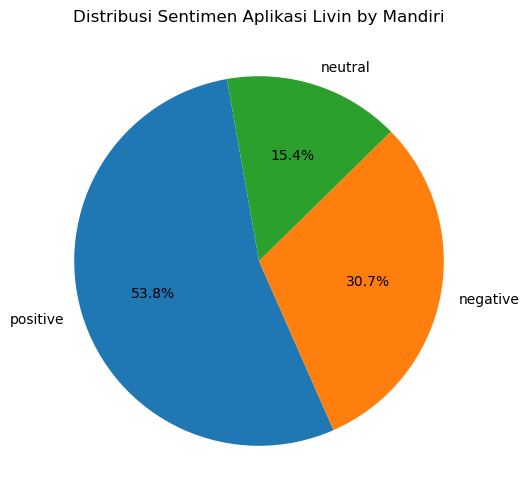

In [28]:
plt.figure(figsize=(8, 6))
plt.pie(data['sentiment'].value_counts(), labels=data['sentiment'].value_counts().index, autopct='%1.1f%%', startangle=100)
plt.title('Distribusi Sentimen Aplikasi Livin by Mandiri')
plt.show()

## 4. Ekstraksi Fitur dengan TF-IDF

In [29]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(data["stemming"])
ordinal = LabelEncoder()
y_tfidf = ordinal.fit_transform(data['sentiment'])

In [30]:
print("Vocabulary:", tfidf.vocabulary_)

Vocabulary: {'aplikasi': 263, 'bantu': 433, 'ulang': 4889, 'kali': 1958, 'masuk': 2670, 'data': 975, 'pribadi': 3625, 'gagal': 1393, 'skensrot': 4240, 'wajah': 5025, 'langsung': 2334, 'making': 2577, 'apdet': 240, 'eror': 1278, 'gax': 1441, 'ksel': 2259, 'klot': 2167, 'assalamualaikum': 314, 'lupa': 2524, 'pasword': 3374, 'livin': 2440, 'login': 2480, 'password': 3365, 'mandiri': 2609, 'hebat': 1636, 'transfer': 4752, 'uang': 4863, 'terang': 4542, 'proses': 3655, 'lanjut': 2338, 'knapa': 2173, 'loading': 2470, 'banget': 416, 'update': 4932, 'henti': 1654, 'muas': 2948, 'bagus': 387, 'transaksi': 4749, 'mahal': 2548, 'perbulnya': 3468, 'potong': 3604, 'biaya': 584, 'saldo': 3936, 'adminitrasi': 35, 'reken': 3770, 'kepotonya': 2109, 'penguna': 3445, 'mudah': 2954, 'bayar': 471, 'qris': 3696, 'pakai': 3331, 'eh': 1239, 'muncul': 2971, 'jaga': 1820, 'aman': 152, 'akun': 108, 'aktivitas': 104, 'non': 3167, 'aktif': 92, 'curiga': 926, 'malu': 2592, 'maluin': 2593, 'beres': 522, 'bank': 427, 

In [31]:
print("TF-IDF Matrix:")
print(X_tfidf.toarray())

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [58]:
with open('l_ekstraksi fitur_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

## 5. Modelling

### 5. a) Early Stopping

In [32]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

### 5. b) Callbacks dengan batas akurasi 96%

In [33]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.96:
            self.model.stop_training = True
custom_callback = Callback()

### 5. c) Skema Model

#### Pelatihan: SVM, Ekstraksi Fitur: TF-IDF, Pembagian Data: 75/25 
#### Pelatihan: LSTM, Ekstraksi Fitur: Embedding-based Sequence Representation, Pembagian Data: 80/20 
#### Pelatihan: Multilayer Perceptron, Ekstraksi Fitur: TF-IDF, Pembagian Data: 70/30

---

### SVM [TF-IDF] (75/25)

In [34]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_tfidf, y_tfidf, test_size=0.25, stratify=y_tfidf, random_state=42)

In [35]:
svm_model = SVC()
svm_model.fit(X_train_svm, y_train_svm)

SVC()

In [36]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],
}

grid_svc = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svc,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_svc.fit(X_train_svm, y_train_svm)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [37]:
print("Best Parameters:", grid_svc.best_params_)

Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [38]:
best_svc = grid_svc.best_estimator_

y_pred_train_svc_tfidf = best_svc.predict(X_train_svm)
y_pred_test_svc_tfidf = best_svc.predict(X_test_svm)

train_svm_tfidf = accuracy_score(y_train_svm, y_pred_train_svc_tfidf)
test_svm_tfidf = accuracy_score(y_test_svm, y_pred_test_svc_tfidf)

print("Train Accuracy:", train_svm_tfidf)
print("Test Accuracy :", test_svm_tfidf)

Train Accuracy: 0.9257333333333333
Test Accuracy : 0.8704


In [39]:
print("Classification Report (Test):")
print(classification_report(y_test_svm, y_pred_test_svc_tfidf))

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       768
           1       0.79      0.68      0.73       386
           2       0.91      0.93      0.92      1346

    accuracy                           0.87      2500
   macro avg       0.85      0.82      0.83      2500
weighted avg       0.87      0.87      0.87      2500



In [40]:
joblib.dump(svm_model, 'model_svm_tfidf.pkl')

['model_svm_tfidf.pkl']

### LSTM [Embedding-based Sequence Representation] (80/20)

In [41]:
X = data['stemming']
le = LabelEncoder()
y_encoded = le.fit_transform(data['sentiment'])

X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(
    data['stemming'], y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
max_words = 5000
max_len = 100
tokenizer_LSTM = Tokenizer(num_words=max_words)
tokenizer_LSTM.fit_on_texts(X_train_LSTM)

X_train_LSTM = tokenizer_LSTM.texts_to_sequences(X_train_LSTM)
X_test_LSTM = tokenizer_LSTM.texts_to_sequences(X_test_LSTM)

X_train_LSTM = pad_sequences(X_train_LSTM, maxlen=max_len)
X_test_LSTM = pad_sequences(X_test_LSTM, maxlen=max_len)

y_train_LSTM = to_categorical(y_train_LSTM)
y_test_LSTM = to_categorical(y_test_LSTM)

In [59]:
with open('l_ekstraksi fitur_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_LSTM, f)

In [43]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_words, 256, input_length=max_len))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(3, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\Rasen\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [44]:
batch_size = 1028
history_LSTM = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_test_LSTM, y_test_LSTM),
    callbacks=[early_stopping]
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5290 - loss: 5.8596 - val_accuracy: 0.5385 - val_loss: 4.9578
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5431 - loss: 4.7200 - val_accuracy: 0.5385 - val_loss: 3.9971
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5410 - loss: 3.8046 - val_accuracy: 0.5525 - val_loss: 3.2216
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5446 - loss: 3.0852 - val_accuracy: 0.5795 - val_loss: 2.6225
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5779 - loss: 2.5170 - val_accuracy: 0.6075 - val_loss: 2.1533
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6164 - loss: 2.0689 - val_accuracy: 0.6620 - val_loss: 1.7660
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6759 - loss: 1.6818 - val_accuracy: 0.7135 - val_loss: 1.4215
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7345 - loss: 1.3305 - val_accuracy: 0.7685 - val_loss: 1.1597
Epoch 9/20
8/8 

In [45]:
train_lstm = model_LSTM.evaluate(X_train_LSTM, y_train_LSTM, verbose=0)[1]
test_lstm = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=0)[1]

print("Train Accuracy:", train_lstm)
print("Test Accuracy :", test_lstm)

Train Accuracy: 0.937874972820282
Test Accuracy : 0.8665000200271606


In [46]:
model_LSTM.save("model_lstm.h5")

### Multilayer Perceptron [TF-IDF] (70/30)

In [47]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_tfidf, test_size=0.3, random_state=42, stratify=y_tfidf
)

In [48]:
y_train_dl = to_categorical(y_train_tfidf)
y_test_dl = to_categorical(y_test_tfidf)

model_mlp = Sequential()
model_mlp.add(Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(256, activation='relu'))
model_mlp.add(Dropout(0.3))
model_mlp.add(Dense(3, activation='softmax'))

model_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_mlp.fit(
    X_train_tfidf, y_train_dl,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_tfidf, y_test_dl),
    callbacks=[early_stopping]
)

Epoch 1/20


c:\Users\Rasen\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5992 - loss: 0.8757 - val_accuracy: 0.8277 - val_loss: 0.4568
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8695 - loss: 0.3791 - val_accuracy: 0.8607 - val_loss: 0.3997
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9261 - loss: 0.2301 - val_accuracy: 0.8447 - val_loss: 0.4656
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9510 - loss: 0.1545 - val_accuracy: 0.8470 - val_loss: 0.4628
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9694 - loss: 0.1026 - val_accuracy: 0.8383 - val_loss: 0.5136


In [49]:
y_pred_train_mlp = model_mlp.predict(X_train_tfidf)
y_pred_test_mlp = model_mlp.predict(X_test_tfidf)

y_pred_train_labels = y_pred_train_mlp.argmax(axis=1)
y_pred_test_labels = y_pred_test_mlp.argmax(axis=1)
y_train_true_labels = y_train_dl.argmax(axis=1)
y_test_true_labels = y_test_dl.argmax(axis=1)

train_mlp = accuracy_score(y_train_true_labels, y_pred_train_labels)
test_mlp = accuracy_score(y_test_true_labels, y_pred_test_labels)

print("Train Accuracy:", train_mlp)
print("Test Accuracy :", test_mlp)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train Accuracy: 0.9394285714285714
Test Accuracy : 0.8606666666666667


In [50]:
model_mlp.save("model_mlp.h5")

### Bar Chart of Model Accuracy

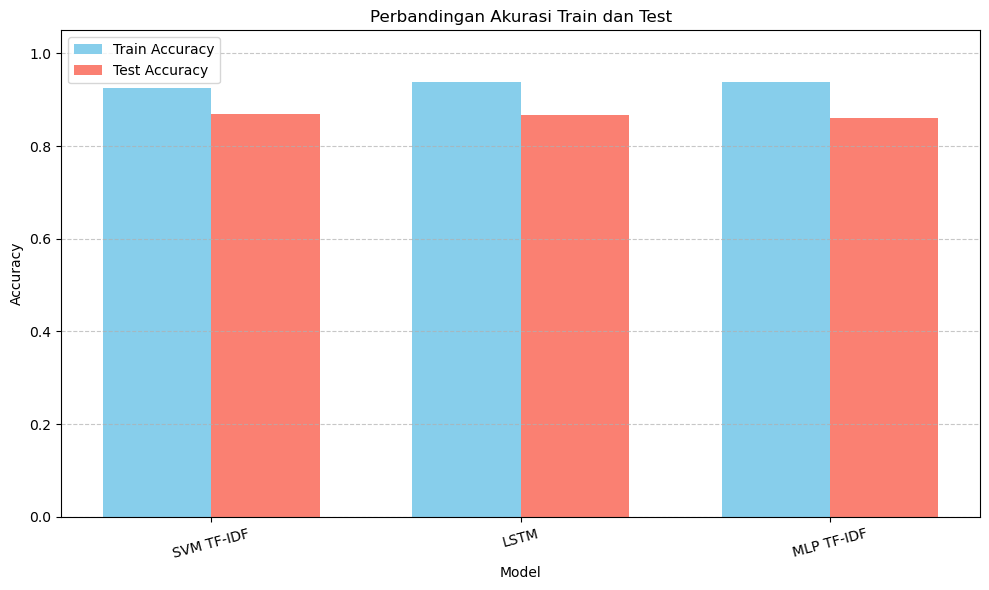

In [51]:
labels = ["SVM TF-IDF", "LSTM", "MLP TF-IDF"]
train_scores = [train_svm_tfidf, train_lstm, train_mlp]
test_scores = [test_svm_tfidf, test_lstm, test_mlp]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=width, label="Train Accuracy", color='skyblue')
plt.bar([i + width for i in x], test_scores, width=width, label="Test Accuracy", color='salmon')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Perbandingan Akurasi Train dan Test")
plt.xticks([i + width / 2 for i in x], labels, rotation=15)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [52]:
labels = ["SVM TF-IDF", "LSTM", "MLP TF-IDF"]
train_scores = [train_svm_tfidf, train_lstm, train_mlp]
test_scores = [test_svm_tfidf, test_lstm, test_mlp]

df_akurasi = pd.DataFrame({
    "Model": labels,
    "Train Accuracy": train_scores,
    "Test Accuracy": test_scores
})

df_akurasi

,Model,Train Accuracy,Test Accuracy
0,SVM TF-IDF,0.925733,0.870400
1,LSTM,0.937875,0.866500
2,MLP TF-IDF,0.939429,0.860667


### 6. Data Testing

In [53]:
ulasan = ["Layanannya ribet dan susah", "Desain sangat baik tapi layanan kurang", "Desain UI nya mantap dan bagus"]
label_asli = ["negative", "neutral", "positive"]

ulasan_tfidf = tfidf.transform(ulasan)

ulasan_seq = tokenizer_LSTM.texts_to_sequences(ulasan)
ulasan_pad = pad_sequences(ulasan_seq, maxlen=100)

In [54]:
pred_svm_tfidf = best_svc.predict(ulasan_tfidf)
pred_lstm = model_LSTM.predict(ulasan_pad)
pred_lstm = np.argmax(pred_lstm, axis=1)
pred_mlp = model_mlp.predict(ulasan_tfidf.toarray())
pred_mlp = np.argmax(pred_mlp, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [55]:
for i, text in enumerate(ulasan):
    print(f"\nUlasan: {text}")
    print(f"Label Asli    : {label_asli[i]}")
    print("SVM TF-IDF    :", ordinal.inverse_transform([pred_svm_tfidf[i]])[0])
    print("LSTM          :", ordinal.inverse_transform([pred_lstm[i]])[0])
    print("MLP TF-IDF    :", ordinal.inverse_transform([pred_mlp[i]])[0])


Ulasan: Layanannya ribet dan susah
Label Asli    : negative
SVM TF-IDF    : negative
LSTM          : negative
MLP TF-IDF    : negative

Ulasan: Desain sangat baik tapi layanan kurang
Label Asli    : neutral
SVM TF-IDF    : neutral
LSTM          : neutral
MLP TF-IDF    : neutral

Ulasan: Desain UI nya mantap dan bagus
Label Asli    : positive
SVM TF-IDF    : positive
LSTM          : positive
MLP TF-IDF    : positive


### 7. **Kesimpulan Akhir**

1. **Preprocessing**  
   Data teks telah melalui proses pembersihan (*text cleaning*) seperti:
   - *Case folding* (ubah ke huruf kecil)
   - *Stopword removal*
   - *Stemming*
   - Ekstraksi fitur dengan dua pendekatan:
     - **TF-IDF** untuk representasi berbasis statistik
     - **Tokenization + Padding** untuk pendekatan deep learning (LSTM)

2. **Modeling**  
   Beberapa model telah dilatih dan dibandingkan:
   - **SVM dengan TF-IDF**
   - **MLP (Neural Network) dengan TF-IDF**
   - **LSTM dengan tokenisasi dan embedding**

3. **Evaluasi Akurasi**
   Tabel berikut merangkum hasil akurasi model:
   
   | Model         | Train Accuracy | Test Accuracy |
   |---------------|----------------|----------------|
   | SVM TF-IDF    | 92.57%         | 87.04%         |
   | LSTM          | 93.79%         | 86.65%         |
   | MLP TF-IDF    | 93.94%         | 86.07%         |

   - **SVM TF-IDF** memberikan hasil **paling stabil** antara train dan test set.
   - **LSTM dan MLP** menunjukkan akurasi pelatihan tinggi, namun sedikit *overfitting* terhadap data uji.

---

### **Rekomendasi ke Depannya**

1. **Penanganan Overfitting**
   - Gunakan lebih banyak data atau augmentasi data (misalnya dengan synonym replacement, back translation, dll).
   - Terapkan teknik regulasi tambahan pada model deep learning seperti **Batch Normalization**, atau lebih banyak variasi pada dropout rate.

2. **Eksperimen Ekstraksi Fitur Lain**
   - Coba gunakan **pre-trained embeddings** seperti GloVe, FastText, atau BERT untuk meningkatkan representasi kata.
   - Kombinasikan TF-IDF dan embedding jika memungkinkan (*feature fusion*).